In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
# data processing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# arima et arixmax 
from pmdarima import auto_arima
# regression regularisée.
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso,Ridge

# methodes d'ensembles
import xgboost as xgb
import lightgbm as lgb
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK


## deep learning
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
import tensorflow as tf  
adam = tf.optimizers.Adam() 
# Tensorflow est une bibliothèque open-source développée par l’équipe Google Brain qui l’utilisait initialement en interne. Elle implémente des méthodes d’apprentissage automatique basées surle principe des réseaux de neurones profonds (deep learning). 
# Keras est une librairie Python qui encapsule l’accès aux fonctions proposées par plusieurs librairies de machine learning, en particulier Tensorflow.
# Une'optimisation d'Adam est une méthode de descente de gradient stochastique basée sur l'estimation adaptative des moments de premier et de second ordre.




In [2]:
sales_df=pd.read_pickle('intermed/sales_full.sav')
sales_df.head()

,DATE_ISO,total_amt,transaction_date,blackFriday2013,blackFriday2012,blackFriday2011,event_value,isMonthEnd,isMonthStart,Weekend_FLG,...,total_amt_mean_lag3,total_amt_mean_lag7,total_amt_mean_lag10,total_amt_std_lag3,total_amt_std_lag7,total_amt_std_lag10,PRCP,TAVG,TMAX,TMIN
0,20110125,48957.025,2011-01-25,6,6,6,6,0,0,0,...,48489.902344,48504.019531,48513.519531,12463.856445,13237.000000,13408.194336,8.164384,33.698630,68.479167,-0.781250
1,20110126,62045.750,2011-01-26,6,6,6,6,0,0,0,...,48957.023438,48957.023438,48957.023438,12463.856445,13237.000000,13408.194336,22.320000,36.698630,65.569444,2.614035
2,20110127,30886.960,2011-01-27,6,6,6,6,0,0,0,...,55501.386719,55501.386719,55501.386719,9255.125977,9255.125977,9255.125977,13.666667,30.616438,62.635135,0.774194
3,20110128,39730.275,2011-01-28,6,6,6,6,0,0,0,...,47296.578125,47296.578125,47296.578125,15645.618164,15645.618164,15645.618164,8.216216,25.438356,52.214286,2.921875
4,20110129,42027.570,2011-01-29,6,6,6,6,0,0,1,...,44220.996094,45405.003906,45405.003906,16057.473633,13323.005859,13323.005859,22.513514,20.972603,46.869565,1.721311


In [3]:
exogenous_features=['Is_holidays','seasonal_week_index','blackFriday2013', 'blackFriday2012','blackFriday2011', 
                    'quarter',	'month'	,'dayofweek',
                    'dayofyear','dayofmonth',
                    'weekofyear', 'year',
                    'event_value','isMonthEnd','isMonthStart','Weekend_FLG',
                    'total_amt_mean_lag3','total_amt_mean_lag7','total_amt_mean_lag10',
                    'total_amt_std_lag3','total_amt_std_lag7','total_amt_std_lag10',
                   'PRCP','TAVG','TMAX'	,'TMIN']

#centree et reduire les exogènes
sales_df[exogenous_features]= StandardScaler(with_mean=True,with_std=True).fit_transform(sales_df[exogenous_features])

In [4]:
df_train = sales_df[sales_df.transaction_date< "2014-01"]
df_test = sales_df[sales_df.transaction_date>= "2014-01"]

## Traditional Algorithms

### ARIMA

In [5]:
model = auto_arima(df_train.total_amt, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.total_amt)
df_test["Forecast_ARIMA"] = model.predict(n_periods=len(df_test))

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=23502.845, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=23498.564, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=23498.523, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=23498.714, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=26258.397, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=23499.221, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=23500.718, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=23501.176, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=24246.617, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.240 seconds


<AxesSubplot:>

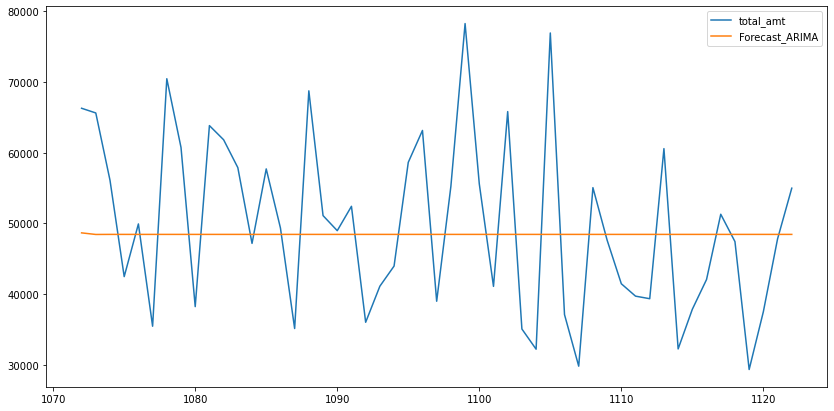

In [6]:
df_test[["total_amt", "Forecast_ARIMA"]].plot(figsize=(14, 7))

### ARIMAX

In [7]:
# SARIMAX Model
sxmodel = auto_arima(sales_df[['total_amt']], exogenous=sales_df[exogenous_features],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=5, max_q=5,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=24638.788, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=24637.858, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=24636.684, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=24636.858, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=34325.301, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=24638.393, Time=0.67 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=24640.363, Time=2.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=24901.156, Time=4.87 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 9.473 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1123
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -12289.342
Date:                Wed, 26 Jan 2022   AIC                          24636.684
Time:                        02:36:05   BIC                          24782.373
Sample:                             0   HQIC                         24691.743
                               - 1123                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept             5.107e+04   1775.461     28.762      0.000    4.76e+04    5.45e+04
Is_holidays           -217.2560    401.184     -0.542      0.588   -1003.562     569.050
seasonal_week_index  -1188.8862   1007.987     -1.179      0.238   -3164.504     786.732
blackFriday2013        897.9163    632.143      1.420      0.155    -341.061    2136.894
blackFriday2012       -276.4256    376.888     -0.733      0.463   -1015.112     462.261
blackFriday2011       -550.4233    512.148     -1.075      0.282   -1554.215     453.368
quarter              -1615.6968   1784.672     -0.905      0.365   -5113.590    1882.196
month                -2.874e+04   6.34e+04     -0.454      0.650   -1.53e+05    9.55e+04
dayofweek              777.4182    685.164      1.135      0.257    -565.479    2120.315
dayofyear             3.358e+04   6.39e+04      0.526      0.599   -9.16e+04    1.59e+05
dayofmonth           -2308.7964   5255.293     -0.439      0.660   -1.26e+04    7991.388
weekofyear           -1188.8862   1007.987     -1.179      0.238   -3164.504     786.732
year                   250.0995    426.202      0.587      0.557    -585.240    1085.439
event_value            544.4304    469.443      1.160      0.246    -375.660    1464.521
isMonthEnd            -257.8092    490.656     -0.525      0.599   -1219.477     703.859
isMonthStart          -113.8877    518.312     -0.220      0.826   -1129.761     901.986
Weekend_FLG           -176.8809    675.621     -0.262      0.793   -1501.073    1147.311
total_amt_mean_lag3   -116.7914    612.981     -0.191      0.849   -1318.213    1084.630
total_amt_mean_lag7    789.0641    888.203      0.888      0.374    -951.782    2529.911
total_amt_mean_lag10  -906.5027    775.692     -1.169      0.243   -2426.830     613.825
total_amt_std_lag3      83.4892    534.739      0.156      0.876    -964.581    1131.559
total_amt_std_lag7    -273.8268    823.245     -0.333      0.739   -1887.358    1339.705
total_amt_std_lag10    -36.1331    784.688     -0.046      0.963   -1574.093    1501.827
PRCP                  -688.7302    510.811     -1.348      0.178   -1689.901     312.440
TAVG                    67.9328   7980.104      0.009      0.993   -1.56e+04    1.57e+04
TMAX                  -751.9341   5222.077     -0.144      0.886    -1.1e+04    9483.149
TMIN                   224.6285   3285.202      0.068      0.945   -6214.248    6663.505
ar.L1                   -0.0531      0.036     -1.483      0.138      -0.123       0.017
sigma2                1.876e+08     86.600   2.17e+06      0.000    1.88e+08    1.88e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                10.88
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.22
Prob(H) (two-sided):                  0.08   Kurtosis:   

<AxesSubplot:>

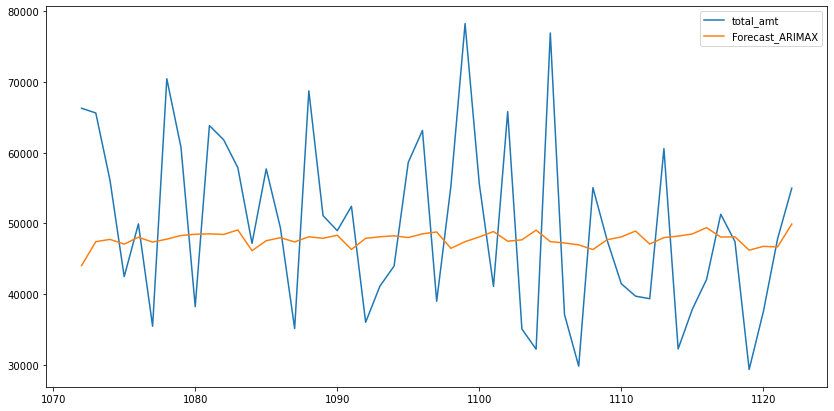

In [8]:
df_test["Forecast_ARIMAX"] = sxmodel.predict(n_periods=len(df_test), exogenous=df_test[exogenous_features])
df_test[["total_amt", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

## Statistical Learning

### LightGBM

In [9]:
params = {"objective": "regression"}
dtrain = lgb.Dataset(df_train[exogenous_features], label=df_train.total_amt)
dvalid = lgb.Dataset(df_test[exogenous_features])
model_lgb = lgb.train(params, train_set=dtrain)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2992
[LightGBM] [Info] Number of data points in the train set: 1072, number of used features: 23
[LightGBM] [Info] Start training from score 48434.391940


<AxesSubplot:>

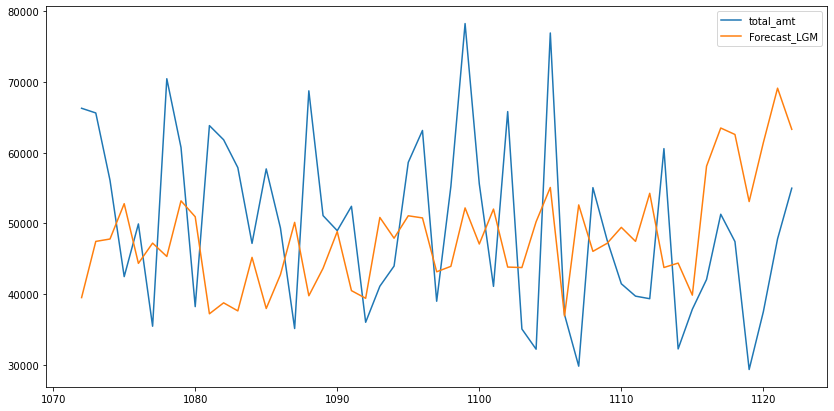

In [10]:
forecast = model_lgb.predict(df_test[exogenous_features])
df_test["Forecast_LGM"] = forecast
df_test[["total_amt","Forecast_LGM"]].plot(figsize=(14, 7))

### XGBoost

In [11]:
X_train, y_train = df_train[exogenous_features],  df_train['total_amt']
X_test, y_test   = df_test[exogenous_features], df_test['total_amt']

In [12]:
df_train[exogenous_features]

,Is_holidays,seasonal_week_index,blackFriday2013,blackFriday2012,blackFriday2011,quarter,month,dayofweek,dayofyear,dayofmonth,...,total_amt_mean_lag3,total_amt_mean_lag7,total_amt_mean_lag10,total_amt_std_lag3,total_amt_std_lag7,total_amt_std_lag10,PRCP,TAVG,TMAX,TMIN
0,-0.173998,-1.444479,0.086637,0.086637,0.086637,-1.305387,-1.551153,-0.999444,-1.451809,1.053619,...,-0.000002,0.000004,-0.000005,7.394978e-07,3.316175e-07,0.000001,-0.617932,-1.492229,-1.471142,-1.524587
1,-0.173998,-1.444479,0.086637,0.086637,0.086637,-1.305387,-1.551153,-0.499054,-1.442423,1.167106,...,0.059641,0.085778,0.099365,7.394978e-07,3.316175e-07,0.000001,0.025469,-1.441122,-1.514426,-1.460921
2,-0.173998,-1.444479,0.086637,0.086637,0.086637,-1.305387,-1.551153,0.001337,-1.433037,1.280593,...,0.895238,1.324926,1.565674,-5.081212e-01,-1.000470e+00,-1.239699,-0.367842,-1.544737,-1.558077,-1.495421
3,-0.173998,-1.444479,0.086637,0.086637,0.086637,-1.305387,-1.551153,0.501727,-1.423651,1.394080,...,-0.152367,-0.228620,-0.272669,5.038520e-01,6.051807e-01,0.667878,-0.615576,-1.632950,-1.713095,-1.455149
4,-0.173998,-1.444479,0.086637,0.086637,0.086637,-1.305387,-1.551153,1.002118,-1.414264,1.507566,...,-0.545064,-0.586781,-0.696489,5.690718e-01,2.160984e-02,-0.025428,0.034264,-1.709028,-1.792603,-1.477661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067,-0.173998,1.717093,0.086637,0.086637,0.086637,1.355138,1.604544,0.501727,1.701915,1.280593,...,0.882893,1.536111,1.463497,1.759573e+00,7.141897e-01,0.186743,0.940298,-0.683187,-0.636985,-0.890584
1068,-0.173998,1.717093,0.086637,0.086637,0.086637,1.355138,1.604544,1.002118,1.711301,1.394080,...,-0.506876,1.341321,1.485854,4.428028e-01,8.791769e-01,0.158184,1.591577,-0.768136,-0.931377,-0.539474
1069,-0.173998,1.717093,0.086637,0.086637,0.086637,1.355138,1.604544,1.502508,1.720687,1.507566,...,0.180836,0.541625,1.157287,-5.418741e-01,3.037743e-01,0.197752,0.415806,-1.068566,-1.113399,-0.836229
1070,-0.173998,-1.642078,0.086637,0.086637,0.086637,1.355138,1.604544,-1.499835,1.730073,1.621053,...,-0.465678,0.358820,1.024161,-1.780099e+00,3.512583e-01,0.271994,-0.603874,-1.183673,-1.185785,-1.228928


In [13]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change ver

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

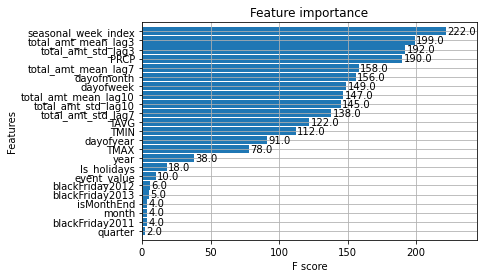

In [14]:
xgb.plot_importance(reg, height=0.9)

<AxesSubplot:>

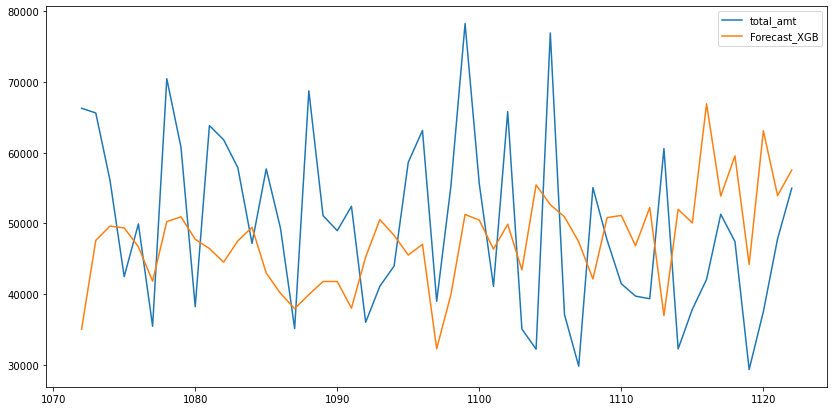

In [15]:
df_test["Forecast_XGB"] = reg.predict(df_test[exogenous_features])
df_test[["total_amt","Forecast_XGB"]].plot(figsize=(14, 7))

### XGBOOSTING tunning

In [16]:
# Define the function hyperopt must optimise
def objective(params):
    num_round = int(params['n_estimators'])
    xgb_reg = xgb.train(params, X_train_matrix, num_round)
    y_pred = xgb_reg.predict(X_test_matrix)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Make DMatrix for calling function, to optimise speed of training
X_train_matrix = xgb.DMatrix(X_train, label=y_train)
X_test_matrix = xgb.DMatrix(X_test)

In [17]:

# Définir l'espace d'optimisation
space = {
    'verbosity': 0, # Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug). 
    'max_depth': hp.choice('max_depth', np.arange(4, 10, 1, dtype=int)), # Maximum depth of a tree. L'augmentation de cette valeur rendra le modèle plus complexe et plus susceptible de sur-ajuster. 0 n'est accepté dans la politique de croissance guidée par perte que lorsque tree_method est défini sur hist et qu'il n'indique aucune limite de profondeur. Méfiez-vous que XGBoost consomme agressivement de la mémoire lors de la formation d'un arbre profond. intervalle: [0,∞] 
    'n_estimators': hp.choice('n_estimators', np.arange(5, 50, 1, dtype=int)),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.3, 0.7, 0.05), # colsample_bytree, colsample_bylevel, colsample_bynode [default=1]. Il s'agit d'une famille de paramètres pour le sous-échantillonnage des colonnes. colsample_bytree est le rapport de sous-échantillon des colonnes lors de la construction de chaque arbre. Le sous-échantillonnage a lieu une fois pour chaque arbre construit. Tous les paramètres colsample_by* ont une plage de (0, 1], la valeur par défaut de 1, et spécifient la fraction de colonnes à sous-échantillonner.
    'min_child_weight': hp.choice('min_child_weight', np.arange(0, 5, 1, dtype=int)), # Minimum sum of instance weight (hessian) needed in a child. Si l'étape de partition de l'arborescence aboutit à un nœud feuille avec la somme du poids de l'instance inférieure à min_child_weight, le processus de construction abandonnera le partitionnement supplémentaire. Dans le cas  de régression linéaire, cela correspond simplement au nombre minimum d'instances nécessaires pour chaque nœud. Plus min_child_weight est grand, plus l'algorithme sera conservateur.  range: [0,∞]
    'subsample': hp.quniform('subsample', 0.3, 1, 0.05), # Subsample ratio of the training instances. Le régler sur 0,5 signifie que XGBoost échantillonnerait au hasard la moitié des données d'entraînement avant de faire pousser des arbres, ce qui évitera le surajustement. Le sous-échantillonnage se produira une fois dans chaque itération de boosting. intervalle: (0,1]
    'gamma': hp.quniform('gamma', 140, 180, 2), # Réduction minimale des pertes requise pour créer une partition supplémentaire sur un nœud feuille de l'arbre. Plus le gamma est grand, plus l'algorithme sera conservateur.  intervalle = [0,∞]
    'learning_rate': hp.quniform('learning_rate', 0.1, 0.6, 0.05),# alias: eta.  Default is 0.3.  Range is [0,1]. Réduction de taille de pas utilisée dans la mise à jour pour éviter le surajustement. Après chaque étape de boosting, nous pouvons directement obtenir le poids des nouvelles features, et eta réduit le poids des features pour rendre le processus de boosting plus conservateur.
    'objective': 'reg:squarederror',
    'lambda': hp.quniform('lambda', 10, 20, 1), #  regularisation L2 des terms poids.. L'augmentation de cette valeur rendra le modèle plus conservateur.
    'alpha': hp.quniform('alpha', 50, 60, 1), #   regularisation L1 des terms poids. L'augmentation de cette valeur rendra le modèle plus conservateur.
    'eval_metric': 'rmse',
    'X_train_matrix': X_train_matrix, 
    'X_test_matrix': X_test_matrix, 
    'y_test': y_test
}

In [18]:
# Exécuter l'optimisation hyperopttrials = Trials()
best = fmin(
    fn=objective,  # objective function
    space=space,   # parameter space
    algo=tpe.suggest,  # surrogate algorithm
    max_evals=200,  # no. of evaluations
    trials=Trials()  # trials object that keeps track of the sample results (optional).  In order to run with trails the output of the objective function has to be a dictionary including at least the keys 'loss' and 'status' which contain the result and the optimization status respectively.
        )

# Imprimer les paramètres optimisés
print("Best = ", best)

100%|██████████████████████████████████████████████| 200/200 [00:25<00:00,  7.86trial/s, best loss: 12166.724175887664]
Best =  {'alpha': 60.0, 'colsample_bytree': 0.35000000000000003, 'gamma': 172.0, 'lambda': 11.0, 'learning_rate': 0.45, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 22, 'subsample': 0.30000000000000004}


In [19]:
reg2 = xgb.XGBRegressor(alpha=54.0, 
                       reg_lambda = 19, 
                       colsample_bytree= 0.30000000000000004,
                       gamma= 154, 
                       learning_rate= 0.55, 
                       max_depth=5,
                       min_child_weight= 4,
                       n_estimators= 20, 
                       subsample= 0.55)
reg2.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric="rmse",
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change ver

XGBRegressor(alpha=54.0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.30000000000000004,
             enable_categorical=False, gamma=154, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.55, max_delta_step=0, max_depth=5,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=54, reg_lambda=19, scale_pos_weight=1,
             subsample=0.55, tree_method='exact', validate_parameters=1,
             verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

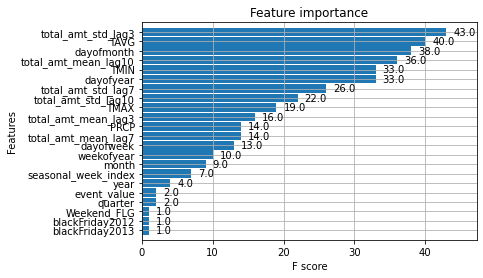

In [20]:
xgb.plot_importance(reg2, height=0.9)

<AxesSubplot:>

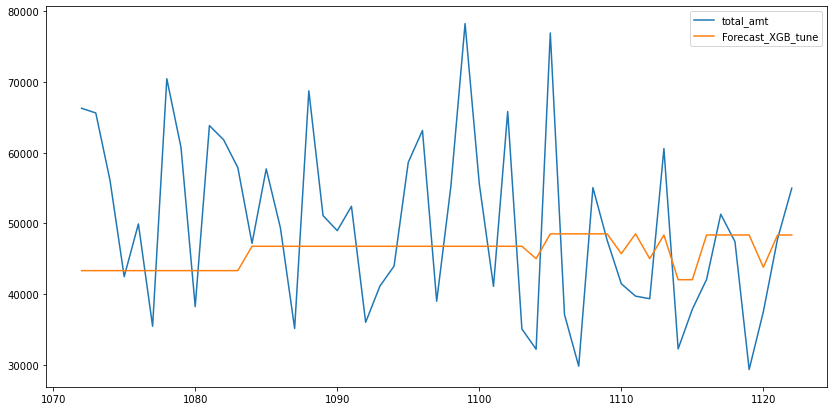

In [21]:
df_test["Forecast_XGB_tune"] = reg2.predict(df_test[exogenous_features])
df_test[["total_amt","Forecast_XGB_tune"]].plot(figsize=(14, 7))

## Ridge and Lasso Regression

In [22]:
# load the dataset
data = sales_df.drop(['transaction_date','DATE_ISO'],axis=1).values
X, y = data[:, :-1], data[:, -1]
# define model
model_ridge = Ridge()
model_lasso = Lasso()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = arange(0, 1, 0.001)
# define search
search_ridge = GridSearchCV(model_ridge, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
search_lasso = GridSearchCV(model_lasso,grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# perform the search
results_ridge = search_ridge.fit(X, y)
results_lasso = search_lasso.fit(X, y)

# summarize
print('MAE Ridge: %.3f' % results_ridge.best_score_)
print('Config: %s' % results_ridge.best_params_)
print('MAE Lasso: %.3f' % results_lasso.best_score_)
print('Config: %s' % results_lasso.best_params_)

MAE Ridge: -0.101
Config: {'alpha': 0.005}
MAE Lasso: -0.101
Config: {'alpha': 0.0}


In [23]:
results_ridge

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.0...
       0.945, 0.946, 0.947, 0.948, 0.949, 0.95 , 0.951, 0.952, 0.953,
       0.954, 0.955, 0.956, 0.957, 0.958, 0.959, 0.96 , 0.961, 0.962,
       0.963, 0.964, 0.965, 0.966, 0.967, 0.968, 0.969, 0.97 , 0.971,
       0.972, 0.973, 0.974, 0.975, 0.976, 0.977, 0.978, 0.979, 0.98 ,
       0.981, 0.982, 0.983, 0.984, 0.985, 0.986, 0.987, 0.988, 0.989,
       0.99 , 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998,
       0.999])},
             scoring='neg_mean_absolute_error')

In [24]:
# define model
model_lasso= Lasso(alpha=0.006)
model_ridge= Ridge(alpha=0.005)
# fit model
model_lasso.fit(X_train, y_train)
model_ridge.fit(X_train, y_train)

#forecast
df_train["Forecast_Lasso_train"] = model_lasso.predict(df_train[exogenous_features])
df_test["Forecast_Lasso"] = model_lasso.predict(df_test[exogenous_features])
df_train["Forecast_Ridge_train"] = model_lasso.predict(df_train[exogenous_features])
df_test["Forecast_Ridge"] = model_ridge.predict(df_test[exogenous_features])


<AxesSubplot:>

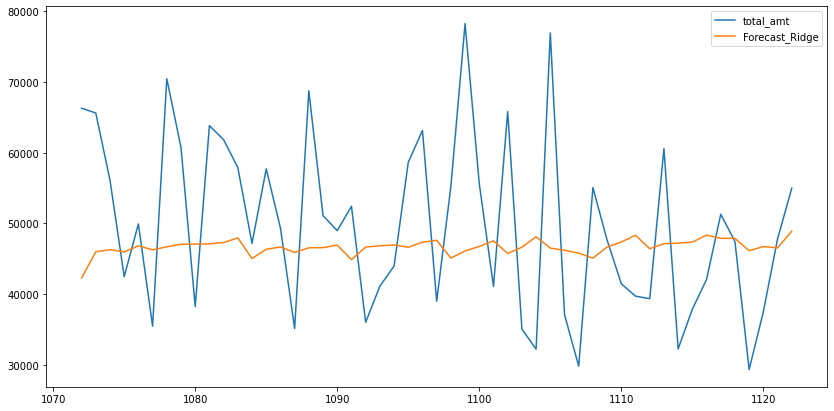

In [25]:
#df_test[["Forecast_Lasso","Forecast_Ridge"]].plot(figsize=(14, 7))
df_test[["total_amt","Forecast_Ridge"]].plot(figsize=(14, 7))

<AxesSubplot:>

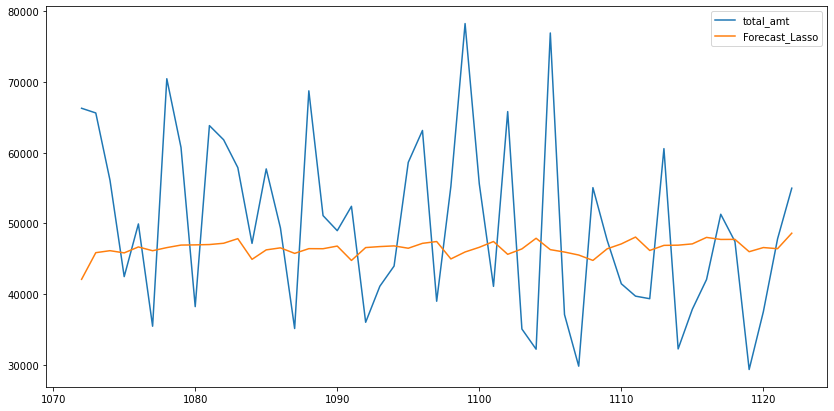

In [26]:
df_test[["total_amt","Forecast_Lasso"]].plot(figsize=(14, 7))

In [27]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) ,3) 

In [28]:
mean_absolute_percentage_error(df_test["total_amt"],df_test["Forecast_Ridge"])

0.22

In [29]:
mean_absolute_percentage_error(df_test["total_amt"],df_test["Forecast_Lasso"])

0.219

In [30]:
mean_absolute_percentage_error(df_test["total_amt"],df_test["Forecast_XGB"])

0.264

In [31]:
mean_absolute_percentage_error(df_test["total_amt"],df_test["Forecast_XGB_tune"])

0.212

In [32]:
mean_absolute_percentage_error(df_test["total_amt"],df_test["Forecast_LGM"])

0.271

## Deep Leraning Algorithms

In [33]:
epochs = 40  # epochs est le nombre maximum d’itérations ; 
batch = 256   # batch_size correspond aux nombre d’observationsque l’on fait passer avant de remettre à jour les poids synaptiques
#lr = 0.0003

Dans cette section, nous passons à un perceptron multicouche. Nous créons toujours une
structure Sequential, dans lequel nous ajoutons successivement deux objets Dense : 
1. le premier fait la jonction entre la couche d’entrée (d’où l’option input_dim indiquant le nombre de variablesprédictives) et la couche cachée qui comporte (units = 3) neurones

==>  fonction d’activation Sigmoides

2. le second entre cette la dernière couche cachée et la sortie à un seul neurone (units = 1). 

==>  fonction d’activation RelU

### MLP

Ici notre modèle aura des caractéristiques d'entrée égales 0 window size

Le problème avec les modèles MLP est que le modèle ne prend pas l'entrée comme des données séquencées,il ne fait que recevoir des INPUTS et ne les traite pas comme des données séquencées, cela peut être un problème puisque le modèle ne le fera pas voir les données avec le modèle de séquence qu'il a.

In [34]:
#instanciation du modèle
model_mlp = Sequential()
##architecture
model_mlp.add(Dense(50, activation="sigmoid", input_dim=X_train.shape[1]))
model_mlp.add(Dense(1,activation='relu'))

#compilation - algorithme d'apprentissage
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1350      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________


In [35]:
#Apprentissage
mlp_history = model_mlp.fit(X_train.values, y_train, validation_data=(X_test.values, y_test), epochs=epochs, verbose=2)

Epoch 1/40
34/34 - 0s - loss: 2538857984.0000 - val_loss: 2618108672.0000 - 470ms/epoch - 14ms/step
Epoch 2/40
34/34 - 0s - loss: 2538763008.0000 - val_loss: 2618060800.0000 - 68ms/epoch - 2ms/step
Epoch 3/40
34/34 - 0s - loss: 2538666752.0000 - val_loss: 2618004224.0000 - 71ms/epoch - 2ms/step
Epoch 4/40
34/34 - 0s - loss: 2538568192.0000 - val_loss: 2617958144.0000 - 71ms/epoch - 2ms/step
Epoch 5/40
34/34 - 0s - loss: 2538466816.0000 - val_loss: 2617913856.0000 - 53ms/epoch - 2ms/step
Epoch 6/40
34/34 - 0s - loss: 2538360832.0000 - val_loss: 2617871104.0000 - 54ms/epoch - 2ms/step
Epoch 7/40
34/34 - 0s - loss: 2538250496.0000 - val_loss: 2617840384.0000 - 53ms/epoch - 2ms/step
Epoch 8/40
34/34 - 0s - loss: 2538137344.0000 - val_loss: 2617804800.0000 - 57ms/epoch - 2ms/step
Epoch 9/40
34/34 - 0s - loss: 2538018816.0000 - val_loss: 2617756928.0000 - 86ms/epoch - 3ms/step
Epoch 10/40
34/34 - 0s - loss: 2537896960.0000 - val_loss: 2617718528.0000 - 94ms/epoch - 3ms/step
Epoch 11/40
34/34

### CNN


Les CNN sont moins couteux en termes de calcul que les RNN : CNN apprend par lots tandis que les RNN s'entraînent de manière séquentielle.
Les CNN ne supposent pas que l'historique est complet : contrairement aux RNN, les CNN apprennent des modèles dans la fenêtre temporelle. Si vous avez des données manquantes, les CNN devraient être utiles.
D'une certaine manière, les CNN peuvent regarder vers l'avenir : les modèles RNN n'apprennent des données qu'avant le pas de temps qu'ils doivent prédire. Les CNN (avec shuffling) peuvent voir les données d'un point de vue plus large

Il existe quatre types de couches pour un réseau de neurones convolutif : 
1. **la couche de convolution** : Son but est de repérer la présence d'un ensemble de features dans les images reçues en entrée. Pour cela, on réalise un filtrage (layer) par convolution , 
2. **la couche de pooling** :Ce type de couche est souvent placé entre deux couches de convolution : elle reçoit en entrée plusieurs feature maps, et applique à chacune d'entre elles l'opération de pooling. En cas d'images, consiste à réduire la taille des images, tout en préservant leurs caractéristiques importantes. La couche de pooling permet de réduire le nombre de paramètres et de calculs dans le réseau. On améliore ainsi l'efficacité du réseau et on évite le sur-apprentissage.Les valeurs maximales sont repérées de manière moins exacte dans les feature maps obtenues après pooling que dans celles reçues en entrée
Ainsi, la couche de pooling rend le réseau moins sensible à la position des features : le fait qu'une feature se situe un peu plus en haut ou en bas, ou même qu'elle ait une orientation légèrement différente ne devrait pas provoquer un changement radical dans la classification de l'image.
3. **la couche Flatten lorsque nous est pas dans un 2D** comme c est le cas avec les imaes
4. **la couche fully-connected** : constitue toujours la dernière couche d'un réseau de neurones, convolutif ou non – elle n'est donc pas caractéristique d'un CNN. Ce type de couche reçoit un vecteur en entrée et produit un nouveau vecteur en sortie. Pour cela, elle applique une combinaison linéaire puis éventuellement une fonction d'activation aux valeurs reçues en entrée

La couche convolutivet être capable d'identifier la séquence temporelles dans les données

In [36]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1072, 26, 1)
Validation set shape (51, 26, 1)


In [37]:
X_train_series

array([[[-0.17399779],
        [-1.44447935],
        [ 0.08663664],
        ...,
        [-1.49222929],
        [-1.47114191],
        [-1.52458717]],

       [[-0.17399779],
        [-1.44447935],
        [ 0.08663664],
        ...,
        [-1.44112171],
        [-1.51442643],
        [-1.46092107]],

       [[-0.17399779],
        [-1.44447935],
        [ 0.08663664],
        ...,
        [-1.54473708],
        [-1.5580767 ],
        [-1.49542054]],

       ...,

       [[-0.17399779],
        [ 1.71709345],
        [ 0.08663664],
        ...,
        [-1.06856554],
        [-1.11339898],
        [-0.83622931]],

       [[-0.17399779],
        [-1.64207765],
        [ 0.08663664],
        ...,
        [-1.18367271],
        [-1.18578494],
        [-1.22892823]],

       [[-0.17399779],
        [-1.64207765],
        [ 0.08663664],
        ...,
        [-1.01630689],
        [-0.97626632],
        [-1.01220027]]])

### CNN

In [38]:
#instanciation du modèle
model_cnn = Sequential()
##architecture
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
#compilation - algorithme d'apprentissage
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                38450     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 38,693
Trainable params: 38,693
Non-trainable params: 0
__________________________________________________

In [39]:
cnn_history = model_cnn.fit(X_train_series, y_train, validation_data=(X_valid_series, y_test), epochs=epochs, verbose=2)

Epoch 1/40
34/34 - 0s - loss: 2526982144.0000 - val_loss: 2564412160.0000 - 449ms/epoch - 13ms/step
Epoch 2/40
34/34 - 0s - loss: 2404277760.0000 - val_loss: 2311192832.0000 - 75ms/epoch - 2ms/step
Epoch 3/40
34/34 - 0s - loss: 2086053248.0000 - val_loss: 1847952768.0000 - 77ms/epoch - 2ms/step
Epoch 4/40
34/34 - 0s - loss: 1614761984.0000 - val_loss: 1283669888.0000 - 78ms/epoch - 2ms/step
Epoch 5/40
34/34 - 0s - loss: 1107622656.0000 - val_loss: 764753984.0000 - 92ms/epoch - 3ms/step
Epoch 6/40
34/34 - 0s - loss: 688200384.0000 - val_loss: 406713440.0000 - 97ms/epoch - 3ms/step
Epoch 7/40
34/34 - 0s - loss: 423195200.0000 - val_loss: 228653280.0000 - 98ms/epoch - 3ms/step
Epoch 8/40
34/34 - 0s - loss: 298620768.0000 - val_loss: 174246688.0000 - 86ms/epoch - 3ms/step
Epoch 9/40
34/34 - 0s - loss: 257291856.0000 - val_loss: 166665136.0000 - 86ms/epoch - 3ms/step
Epoch 10/40
34/34 - 0s - loss: 246368336.0000 - val_loss: 168912448.0000 - 86ms/epoch - 3ms/step
Epoch 11/40
34/34 - 0s - los

### LSTM

LSTM voit réellement les données d'entrée comme une séquence

Il est donc capable d'apprendre des modèles à partir de données séquencées (en supposant qu'elles existent) mieux que les autres,en particulier les modèles à partir de longues séquences.

In [40]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [41]:
lstm_history = model_lstm.fit(X_train_series, y_train, validation_data=(X_valid_series, y_test), epochs=epochs, verbose=2)

Epoch 1/40
34/34 - 1s - loss: 4435899904.0000 - val_loss: 2618221568.0000 - 1s/epoch - 44ms/step
Epoch 2/40
34/34 - 0s - loss: 2538939136.0000 - val_loss: 2618208768.0000 - 471ms/epoch - 14ms/step
Epoch 3/40
34/34 - 0s - loss: 2538927360.0000 - val_loss: 2618197248.0000 - 481ms/epoch - 14ms/step
Epoch 4/40
34/34 - 0s - loss: 2538916352.0000 - val_loss: 2618187264.0000 - 356ms/epoch - 10ms/step
Epoch 5/40
34/34 - 0s - loss: 2538907648.0000 - val_loss: 2618178560.0000 - 381ms/epoch - 11ms/step
Epoch 6/40
34/34 - 0s - loss: 2538899456.0000 - val_loss: 2618170624.0000 - 349ms/epoch - 10ms/step
Epoch 7/40
34/34 - 0s - loss: 2538891520.0000 - val_loss: 2618163200.0000 - 366ms/epoch - 11ms/step
Epoch 8/40
34/34 - 0s - loss: 2538884352.0000 - val_loss: 2618156032.0000 - 355ms/epoch - 10ms/step
Epoch 9/40
34/34 - 0s - loss: 2538877696.0000 - val_loss: 2618149376.0000 - 377ms/epoch - 11ms/step
Epoch 10/40
34/34 - 0s - loss: 2538871552.0000 - val_loss: 2618143232.0000 - 385ms/epoch - 11ms/step
Ep

### CNN-LSTM 

"The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."

For more informations : https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/

In [42]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (1072, 2, 13, 1)
Validation set shape (51, 2, 13, 1)


In [43]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [44]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, y_train, validation_data=(X_valid_series_sub, y_test), epochs=epochs, verbose=2)

Epoch 1/40
34/34 - 2s - loss: 2497993984.0000 - val_loss: 2359843072.0000 - 2s/epoch - 48ms/step
Epoch 2/40
34/34 - 0s - loss: 1688321664.0000 - val_loss: 492003136.0000 - 121ms/epoch - 4ms/step
Epoch 3/40
34/34 - 0s - loss: 348687968.0000 - val_loss: 260669568.0000 - 192ms/epoch - 6ms/step
Epoch 4/40
34/34 - 0s - loss: 256513440.0000 - val_loss: 187153264.0000 - 123ms/epoch - 4ms/step
Epoch 5/40
34/34 - 0s - loss: 245520912.0000 - val_loss: 178768240.0000 - 134ms/epoch - 4ms/step
Epoch 6/40
34/34 - 0s - loss: 238525936.0000 - val_loss: 181274144.0000 - 124ms/epoch - 4ms/step
Epoch 7/40
34/34 - 0s - loss: 231886176.0000 - val_loss: 192982080.0000 - 122ms/epoch - 4ms/step
Epoch 8/40
34/34 - 0s - loss: 227084320.0000 - val_loss: 188324688.0000 - 123ms/epoch - 4ms/step
Epoch 9/40
34/34 - 0s - loss: 223148160.0000 - val_loss: 175570304.0000 - 129ms/epoch - 4ms/step
Epoch 10/40
34/34 - 0s - loss: 220353776.0000 - val_loss: 175950192.0000 - 135ms/epoch - 4ms/step
Epoch 11/40
34/34 - 0s - los

In [45]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, y_train, validation_data=(X_valid_series_sub, y_test), epochs=epochs, verbose=2)

Epoch 1/40
34/34 - 0s - loss: 194779328.0000 - val_loss: 150398112.0000 - 176ms/epoch - 5ms/step
Epoch 2/40
34/34 - 0s - loss: 194841552.0000 - val_loss: 153899392.0000 - 144ms/epoch - 4ms/step
Epoch 3/40
34/34 - 0s - loss: 194650240.0000 - val_loss: 150560192.0000 - 126ms/epoch - 4ms/step
Epoch 4/40
34/34 - 0s - loss: 194199680.0000 - val_loss: 150340528.0000 - 140ms/epoch - 4ms/step
Epoch 5/40
34/34 - 0s - loss: 194400176.0000 - val_loss: 149204128.0000 - 128ms/epoch - 4ms/step
Epoch 6/40
34/34 - 0s - loss: 193874000.0000 - val_loss: 150591024.0000 - 126ms/epoch - 4ms/step
Epoch 7/40
34/34 - 0s - loss: 193904848.0000 - val_loss: 151631184.0000 - 175ms/epoch - 5ms/step
Epoch 8/40
34/34 - 0s - loss: 193691456.0000 - val_loss: 150350080.0000 - 198ms/epoch - 6ms/step
Epoch 9/40
34/34 - 0s - loss: 193619312.0000 - val_loss: 149785552.0000 - 212ms/epoch - 6ms/step
Epoch 10/40
34/34 - 0s - loss: 195100192.0000 - val_loss: 153905328.0000 - 180ms/epoch - 5ms/step
Epoch 11/40
34/34 - 0s - loss

In [46]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_test.values)
print('Train mape:', mean_absolute_percentage_error(y_train,mlp_train_pred))
print('Test mape:', mean_absolute_percentage_error(y_test,mlp_valid_pred))

Train mape: 0.998
Test mape: 0.999


In [47]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train mape:', mean_absolute_percentage_error(y_train,cnn_train_pred))
print('Test mape:', mean_absolute_percentage_error(y_test,cnn_valid_pred))

Train mape: 0.276
Test mape: 0.246


In [48]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_lstm.predict(X_valid_series)
print('Train mape:', mean_absolute_percentage_error(y_train,lstm_train_pred))
print('Test mape:', mean_absolute_percentage_error(y_test,lstm_valid_pred))

Train mape: 1.0
Test mape: 1.0


In [49]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train mape:', mean_absolute_percentage_error(y_train,cnn_lstm_train_pred))
print('Test mape:', mean_absolute_percentage_error(y_test,cnn_lstm_valid_pred))

Train mape: 0.27
Test mape: 0.227


## Conclusion

No need to go with neural netweek to imporve the forecasts, we have always a MAPE aroud 25%
So let's go with XGBoost or Ridge Regressions.
We will deploy juste on of these models